##### the cell below installs libraries you may need via conda-jupyter enviroment.

In [ ]:
#installs for EEG and fNIRS processing. uncomment if needed to install in Jupyter
# !pip install mne
# !pip install mne_nirs


In [242]:
import os.path as op
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from itertools import compress
from scipy import stats as st


import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair,
                                    scalp_coupling_index)
from mne import Epochs, events_from_annotations
%matplotlib auto

Using matplotlib backend: QtAgg


### The cell below scans a directory for all fNIRS data files and arranges their paths in lists. It's done for group analysis

In [243]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

fnirs_dir = r"C:\Users\Admin\Desktop\IMAGERY-FNIRS"

subfolders = fast_scandir(fnirs_dir)

subj_names = sorted([(i.split('\\')[-1]) for i in subfolders if len(i.split('\\')[-1])==2])
recordings_names = sorted([i for i in subfolders if '_' in i and '.' not in i])

In [317]:
filename = recordings_names[70]
splitting_slash = '\\'
CONDITION = filename.split(splitting_slash)[-1].split('_')[-1]
SUBJECT = filename.split(splitting_slash)[-1].split('_')[0]
# filename = ... #insert the path to a folder\file were fNIRS data are stored


#there are several ways to read fNIRS data. 
# maybe for LUMO format there will be another option
raw_intensity = mne.io.read_raw_nirx(
    filename,
    verbose=True
)



raw_od = mne.preprocessing.nirs.optical_density(raw_intensity) #from row wavelength data
raw_od_shorts = mne_nirs.channels.get_short_channels(raw_od)
sci_shorts = scalp_coupling_index( 
                                  raw_od_shorts, 
                                  h_freq=1.35, 
                                  h_trans_bandwidth=0.1
                                  )
bad_sci_shorts = list(compress(raw_od_shorts.ch_names, sci_shorts < 0.6))
raw_od.drop_channels(bad_sci_shorts)

#if you have short channels, you can perform some regression to exclude skin bloodflow
raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)
raw_od.drop_channels(['S2_D4 760', 'S2_D4 850']) #we had a non-existent channel
raw_od = mne_nirs.channels.get_long_channels(raw_od)
sci = scalp_coupling_index( 
                           raw_od, 
                           h_freq=1.35, 
                           h_trans_bandwidth=0.1
                           )
bad_sci = list(compress(raw_od.ch_names, sci < 0.6))
bad_sci = [i.replace('760', 'hbr') for i in bad_sci]
bad_sci = [i.replace('850', 'hbr') for i in bad_sci]
raw_od.resample(1.0)
raw_od = temporal_derivative_distribution_repair(raw_od) #repairs movement artifacts

Loading C:\Users\Admin\Desktop\IMAGERY-FNIRS\NS\NS_ME
Reading 0 ... 8110  =      0.000 ...   797.245 secs...


In [325]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR

fig = mne.viz.plot_sensors(raw_haemo.info, kind='select')


In [326]:
fig

(<Figure size 1920x983 with 1 Axes>, ['S28_D27 hbo', 'S29_D28 hbo'])

In [328]:
drop_chans = ['S2_D4 hbo',
 'S2_D1 hbo',
  'S2_D3 hbo',
  'S3_D1 hbo',
  'S3_D4 hbo',
  'S31_D27 hbo',
  'S31_D30 hbo',
              'S28_D27 hbo', 'S29_D28 hbo',
  'S32_D28 hbo',
  'S32_D31 hbo']
drop_chans_hbo = [i.replace('hbo', '760') for i in drop_chans]
drop_chans_hbr = [i.replace('hbo', '850') for i in drop_chans]
drop_chans_hbo + drop_chans_hbr

['S2_D4 760',
 'S2_D1 760',
 'S2_D3 760',
 'S3_D1 760',
 'S3_D4 760',
 'S31_D27 760',
 'S31_D30 760',
 'S28_D27 760',
 'S29_D28 760',
 'S32_D28 760',
 'S32_D31 760',
 'S2_D4 850',
 'S2_D1 850',
 'S2_D3 850',
 'S3_D1 850',
 'S3_D4 850',
 'S31_D27 850',
 'S31_D30 850',
 'S28_D27 850',
 'S29_D28 850',
 'S32_D28 850',
 'S32_D31 850']

In [318]:
events, ids = mne.events_from_annotations(raw_haemo)
ids["Rest"] = 2
ids["Sensorimotor"] = 1

#here we're removing events labels we do not need
def popper(ids, ids_key):
    try:
        ids.pop(ids_key)
    except:
        pass
        
ids_to_pop = ["2.0", "33.0", "1.0", "2", "1", "33",]
    
for i in ids_to_pop:
    popper(ids, i)

tmin, tmax = 0, 14
epochs = mne.Epochs(
                    raw_haemo,
                    events,
                    event_id=ids,
                    baseline=None,
                    tmin=tmin,
                    tmax=tmax,
                    preload=True,
                    verbose=False,
#                     picks=picks
                   )


rest_epochs_raw = epochs["Rest"]
smr_epochs_raw = epochs["Sensorimotor"]

raw_haemo.pick_channels(ch_names=right_side_hbo+left_side_hbo)

Used Annotations descriptions: ['1.0', '2.0']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\3481013990.py:35: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_haemo.pick_channels(ch_names=right_side_hbo+left_side_hbo)


<RawNIRX | NS_ME, 24 x 797 (796.0 s), ~223 kB, data loaded>

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\1213728510.py:1: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  smr_epochs_raw.average().compute_psd().plot()


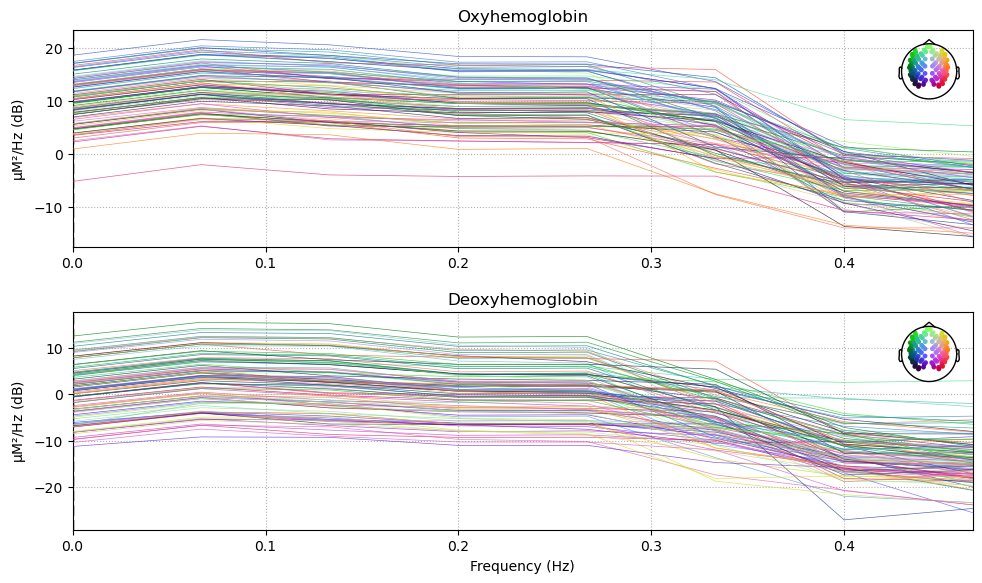

In [319]:
smr_epochs_raw.average().compute_psd().plot()

In [278]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR

#filtering parameters are wery tricky. you may like to set your own filtering borders.
low_f_border, high_f_border = 0.05, 0.08
# h_trans_bandwidth, l_trans_bandwidth = 0.1, 0.01
# h_trans_bandwidth, l_trans_bandwidth = 0.15, 0.015
# h_trans_bandwidth, l_trans_bandwidth = 0.2, 0.02

raw_haemo = raw_haemo.filter(low_f_border, high_f_border,
#                              h_trans_bandwidth=h_trans_bandwidth,
#                              l_trans_bandwidth=l_trans_bandwidth, 
                             n_jobs=-1)
#this is optional. it makes HbO and HbR to -correlate to a greater extent
raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)


channel_std = np.std(raw_haemo.get_data(), axis=(1))

# Define a threshold for standard deviation
threshold = 1.25*10**-5  
outlier_channels = list(np.where(channel_std > threshold)[0])
channels_to_fix = [raw_haemo.ch_names[i] for i in outlier_channels]
channels_to_interpolate_hbr = list(set([i.replace('hbo', 'hbr') 
                                        for i in channels_to_fix] + bad_sci))
channels_to_interpolate_hbo = [i.replace('hbr', 'hbo') for i in channels_to_interpolate_hbr]
channels_to_interpolate = channels_to_interpolate_hbr + channels_to_interpolate_hbo
print(channels_to_interpolate, '\n', len(channels_to_interpolate))
raw_haemo.info['bads'] = channels_to_interpolate

# Remove outlier channels from the Epochs object
raw_haemo = raw_haemo.interpolate_bads()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.08 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 0.08 Hz
- Upper transition bandwidth: 0.42 Hz (-6 dB cutoff frequency: 0.29 Hz)
- Filter length: 67 samples (67.000 s)

['S6_D6 hbr', 'S12_D11 hbr', 'S4_D9 hbr', 'S12_D21 hbr', 'S10_D16 hbr', 'S5_D12 hbr', 'S20_D18 hbr', 'S10_D7 hbr', 'S10_D19 hbr', 'S14_D15 hbr', 'S24_D19 hbr', 'S9_D18 hbr', 'S27_D30 hbr', 'S6_D7 hbr', 'S1_D6 hbr', 'S29_D28 hbr', 'S6_D13 hbr', 'S6_D6 hbo', 'S12_D11 hbo', 'S4_D9 hbo', 'S12_D21 hbo', 'S10_D16 hbo', 'S5_D12 hbo', 'S20_D18 hbo', 'S10_D7 hbo', 'S10_D19 hbo', 'S14_D15 hbo', 'S24_D19 hbo', 'S9_D18 hbo', 'S27_D30 hbo', 'S6_D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    0.0s finished
C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\1032182352.py:31: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_haemo = raw_haemo.interpolate_bads()


### This cell is about selecting a subgroup of channels. In our case, we wanted to select channels around C3 and C4 10-20 leads (corresponding locations are listed). So we end up having a pair of groups of ~20 long channels corresponding for each side's sensorimotor zone.

In [279]:
chnames = raw_haemo.ch_names


# C3 = ['FC3', 'FCC5h', 'FCC3h', 'FCC1h', 'C5', 'C1', 'CCP5h', 'CCP3h']
# C4 = ['FC4', 'FCC6h', 'FCC4h', 'FCC2h', 'C2', 'C6', 'CCP4h', 'CCP6h']

C3 = ['C5', 'C1', 'CCP5h', 'CCP3h']
C4 = ['C2', 'C6', 'CCP4h', 'CCP6h']

optodes_to_channels = {
                  'FC3':'D10',
                  'FC4':'D11',
                  'FTT7h':'D12',
                  'FCC5h':'S9',
                  'FCC3h':'D13',
                  'FCC1h':'S10',
                  'FCC2h':'S11',
                  'FCC4h':'D14',
                  'FCC6h':'S12',
                  'FTT8h':'D15',
                  'C5':'S13',
                  'C1':'D16',
                  'C2':'D17',
                  'C6':'S14',
                  'TTP7h':'S15',
                  'CCP5h':'D18',
                  'CCP3h':'S16',
                  'CCP1h':'D19',
                  'CCP2h':'D20',
                  'CCP4h':'S17',
                  'CCP6h':'D21',
                  'TTP8h':'S18'
                  }


C3_channels = [optodes_to_channels[i] for i in C3]
C4_channels = [optodes_to_channels[i] for i in C4]

def chans_of_interest(optodes_of_interest):
    chans_hbo = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbo' in x]
    chans_hbr = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbr' in x]

    return chans_hbo, chans_hbr

C3_chans_of_interest_hbo, C3_chans_of_interest_hbr = chans_of_interest(C3_channels)
C4_chans_of_interest_hbo, C4_chans_of_interest_hbr = chans_of_interest(C4_channels)

###############################################

In [280]:
def clean_epochs(raw_haemo, events, ids, tmin=0, tmax=14):
    '''This functions takes raw_haemo recording, events and ids, 
    splits them into epochs according to events timings and ids. 
    There is and inside function epoch_rejector, which recjects top and low 10% of
    deviant epochs in each epochs' type ''' 

    tmin, tmax = tmin, tmax
    epochs = mne.Epochs(
                        raw_haemo,
                        events,
                        event_id=ids,
                        baseline=None,
                        tmin=tmin,
                        tmax=tmax,
                        preload=True,
                        verbose=False,
                        # picks=picks
                       )


    rest_epochs_raw = epochs["Rest"]
    smr_epochs_raw = epochs["Sensorimotor"]

    info = smr_epochs_raw.info
    chans = mne.io.pick.channel_indices_by_type(info)
    info_hbo = mne.pick_info(info,chans['hbo'])
    info_hbr = mne.pick_info(info,chans['hbr'])
    hbo_chnames = info_hbo.ch_names
    hbr_chanames = info_hbr.ch_names


    smr_epochs_data = smr_epochs_raw.get_data()
    rest_epochs_data = rest_epochs_raw.get_data()

    def epochs_rejector(epochs_data, criterion='median', 
                        time_limits = (4, 12),
                        lower=0.10, upper=0.90):

        epochs_data = epochs_data[:, :, time_limits[0]:time_limits[1]]

        if criterion == 'median':

            median = np.median(epochs_data, axis=1)
            median = np.median(median, axis=1)
            lower_quantile = np.quantile(median, lower)
            upper_quantile = np.quantile(median, upper)

            reject_bool_negative = median < lower_quantile
            reject_bool_positive = median > upper_quantile

            reject_bool = np.logical_or(reject_bool_negative, reject_bool_positive)

        return reject_bool

    smr_reject_bool = epochs_rejector(smr_epochs_data, 
#                                       lower=0.15, upper=0.95
                                     )
    rest_reject_bool = epochs_rejector(rest_epochs_data, 
#                                        upper=0.85, lower=0.05
                                      )

    smr_epochs = smr_epochs_raw.drop(smr_reject_bool)
    rest_epochs = rest_epochs_raw.drop(rest_reject_bool)

    evoked_smr = smr_epochs.average()
    evoked_rest = rest_epochs.average()

    return smr_epochs, rest_epochs, evoked_smr, evoked_rest

In [281]:
events, ids = mne.events_from_annotations(raw_haemo)
ids["Rest"] = 2
ids["Sensorimotor"] = 1

#here we're removing events labels we do not need
def popper(ids, ids_key):
    try:
        ids.pop(ids_key)
    except:
        pass
        
ids_to_pop = ["2.0", "33.0", "1.0", "2", "1", "33",]
    
for i in ids_to_pop:
    popper(ids, i)

smr_epochs, rest_epochs, _, _ = clean_epochs(raw_haemo, events=events, ids=ids)
    

Used Annotations descriptions: ['1.0', '2.0']
Dropped 4 epochs: 5, 14, 18, 19
Dropped 4 epochs: 6, 7, 8, 11
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


### The cell below will plot hemodynamic curves for each epoch and haemoglobin type. There will be to graphs for left and right hemispheres, as we'd like to see the activation profile in both hemispheres' sensorimotor zones

In [282]:
#you can set condition and subject by hand or get it from file's name
picks_hbo_left, picks_hbr_left = C3_chans_of_interest_hbo, C3_chans_of_interest_hbr
picks_hbo_right, picks_hbr_right = C4_chans_of_interest_hbo, C4_chans_of_interest_hbr

smr_epochs_left = smr_epochs.copy().pick_channels(picks_hbo_left + picks_hbr_left)
smr_epochs_right = smr_epochs.copy().pick_channels(picks_hbo_right + picks_hbr_right)
rest_epochs_left = rest_epochs.copy().pick_channels(picks_hbo_left + picks_hbr_left)
rest_epochs_right = rest_epochs.copy().pick_channels(picks_hbo_right + picks_hbr_right)

smr_evoked_left = smr_epochs_left.copy().average(picks=picks_hbo_left)
data_smr = smr_evoked_left.get_data()
mode = st.mode(np.argmax(data_smr, axis=0)[5:12])[0][0]
top_channel_C3_hbo = smr_evoked_left.ch_names[mode]
print(top_channel_C3_hbo)
top_channel_C3_hbr = [top_channel_C3_hbo.replace('o', 'r'),]
top_channel_C3 = [top_channel_C3_hbo.removesuffix(' hbo'),]
top_channel_C3_hbo = [top_channel_C3_hbo, ]

smr_evoked_right = smr_epochs_right.copy().average(picks=picks_hbo_right)
data_smr = smr_evoked_right.get_data()
mode = st.mode(np.argmax(data_smr, axis=0)[5:12])[0][0]
top_channel_C4_hbo = smr_evoked_right.ch_names[mode]
top_channel_C4_hbr = [top_channel_C4_hbo.replace('o', 'r'),]
top_channel_C4 = [top_channel_C4_hbo.removesuffix(' hbo'),]
top_channel_C4_hbo = [top_channel_C4_hbo, ]


#we're averaging each type of epochs (target and rest). on this mean data, we pick
#prepared sets of channels for each hemisphere -- these channels should more or less
#cover the sensorimotor zone

# evoked_dict_left = {f'{CONDITION}/HbO': smr_epochs_left.copy().average(picks=top_channel_C3_hbo),
#                f'{CONDITION}/HbR': smr_epochs_left.copy().average(picks=top_channel_C3_hbr),
#                'Rest/HbO': rest_epochs_left.copy().average(picks=top_channel_C3_hbo),
#                'Rest/HbR': rest_epochs_left.copy().average(picks=top_channel_C3_hbr)}

# evoked_dict_right = {f'{CONDITION}/HbO': smr_epochs_right.copy().average(picks=top_channel_C4_hbo),
#                f'{CONDITION}/HbR': smr_epochs_right.copy().average(picks=top_channel_C4_hbr),
#                'Rest/HbO': rest_epochs_right.copy().average(picks=top_channel_C4_hbo),
#                'Rest/HbR': rest_epochs_right.copy().average(picks=top_channel_C4_hbr)}

evoked_dict_left = {f'{CONDITION}/HbO': smr_epochs_left.copy().average(picks=picks_hbo_left),
               f'{CONDITION}/HbR': smr_epochs_left.copy().average(picks=picks_hbr_left),
               'Rest/HbO': rest_epochs_left.copy().average(picks=picks_hbo_left),
               'Rest/HbR': rest_epochs_left.copy().average(picks=picks_hbr_left)}

evoked_dict_right = {f'{CONDITION}/HbO': smr_epochs_right.copy().average(picks=picks_hbo_right),
               f'{CONDITION}/HbR': smr_epochs_right.copy().average(picks=picks_hbr_right),
               'Rest/HbO': rest_epochs_right.copy().average(picks=picks_hbo_right),
               'Rest/HbR': rest_epochs_right.copy().average(picks=picks_hbr_right)}


# rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict_left:
    evoked_dict_left[condition].rename_channels(lambda x: x[:-4])

for condition in evoked_dict_right:
    evoked_dict_right[condition].rename_channels(lambda x: x[:-4])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Rest=dict(linestyle='dashed'))


#this is made of scales unification
y_min = min(evoked_dict_left[f'{CONDITION}/HbO'].get_data().min(),
            evoked_dict_right[f'{CONDITION}/HbO'].get_data().min(),()) * 2*10**6
y_max = max(evoked_dict_left[f'{CONDITION}/HbO'].get_data().max(),
            evoked_dict_right[f'{CONDITION}/HbO'].get_data().max(),()) * 2*10**6
ylim = {'hbo':[y_min, y_max],
        'hbr':[y_min, y_max]}

left_plot = mne.viz.plot_compare_evokeds(evoked_dict_left,
                                         combine="mean",
                                         ci=0.95,
                                         colors=color_dict,
                                         styles=styles_dict,
                                         title=f'{CONDITION} and Rest trials LEFT hemisphere\nSubject {SUBJECT}',
                                         axes=axes[0],
                                         ylim=ylim,
                                         truncate_xaxis=False) 

right_plot = mne.viz.plot_compare_evokeds(evoked_dict_right,
                                           combine="mean",
                                           ci=0.95,
                                           colors=color_dict,
                                           styles=styles_dict,
                                           title=f'{CONDITION} and Rest trials RIGHT hemisphere\nSubject {SUBJECT}',
                                           axes=axes[1],
                                           ylim=ylim,
                                           truncate_xaxis=False)  # Use the second subplot axes

target_fig_curves = right_plot[0] #this is a figure for our hemodynamic curves for epochs and haemo types

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
S15_D18 hbo
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a l

C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\346215621.py:5: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  smr_epochs_left = smr_epochs.copy().pick_channels(picks_hbo_left + picks_hbr_left)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\346215621.py:6: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  smr_epochs_right = smr_epochs.copy().pick_channels(picks_hbo_right + picks_hbr_right)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\346215621.py:7: FutureWarning: The default for pick_channels will change from ordered=False to orde

In [283]:
a = evoked_dict_right[f'{CONDITION}/HbO'].get_data()
b = evoked_dict_right[f'{CONDITION}/HbR'].get_data()
c = evoked_dict_right['Rest/HbO'].get_data()
d = evoked_dict_right['Rest/HbR'].get_data()
np.stack(arrays=[a, b, c, d]).shape

(4, 13, 15)

### This will plot topomaps for each epoch type in timeline (averaged over all epochs of a type).  Target epochs (SMR) are above, rest epochs are below

In [284]:
#we set a timeline for each epoch
times = np.arange(2, 14, 2)
haemo_picks = 'hbo'

if haemo_picks=='hbo':
    topo_haemo = 'HbO'
else:
    topo_haemo = 'HbR'

topomap_args = dict(extrapolate='local')

smr_evoked = smr_epochs.average(picks=haemo_picks)
rest_evoked = rest_epochs.average(picks=haemo_picks)

#this is made for colorbar normalization
vmin = min(smr_evoked.data.min(), rest_evoked.data.min())*10**6
vmax = max(smr_evoked.data.max(), rest_evoked.data.max())*10**6
vlim = (vmin, vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))

# create a figure to contain both topomap plots
fig, axes = plt.subplots(2, len(times), figsize=(14, 7))

# loop through times and plot the topomaps for smr epochs and rest epochs
smr_fig = smr_evoked.plot_topomap(times, axes=axes[0, :],
                        # title=f'SMR {time} ms',
                        colorbar=False,
                        show=False,
#                         vlim=vlim,
                        **topomap_args)
rest_fig = rest_evoked.plot_topomap(times, axes=axes[1, :],
                        #  title=f'Rest {time} ms',
                          show=False,
                          colorbar=False,
#                           vlim=vlim,
                          **topomap_args)

cbaxes = fig.add_axes([0.095, 0.25, 0.02, 0.5]) # setup colorbar axes. 

cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
cbar.set_label(f'{topo_haemo} concentration, Δ μM\L', loc='center', size=12)

fig.subplots_adjust( 
                    top=0.910, 
                    bottom=0.06,
                    left=0.150, 
                    right=0.950, 
                    hspace=0.195, 
                    wspace=0.0 
                   )

x_top, y_top = 0.55, 0.95
x_bottom, y_bottom = 0.55, 0.5

fig.text(
         x=x_top, y=y_top, 
         s=f'{CONDITION} {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center' 
        )
fig.text( 
         x=x_bottom, y=y_bottom, 
         s=f'Rest {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center'
        )#we set a timeline for each epoch



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Text(0.55, 0.5, 'Rest HbO changes timeline')

In [ ]:
fig, axes = plt.subplots(2, len(times), figsize=(14, 7))

# loop through times and plot the topomaps for smr epochs and rest epochs
smr_fig = smr_evoked.plot_topomap(times, axes=axes[0, :],
                        # title=f'SMR {time} ms',
                        colorbar=False,
                        show=False,
#                         vlim=vlim,
                        **topomap_args)
rest_fig = rest_evoked.plot_topomap(times, axes=axes[1, :],
                        #  title=f'Rest {time} ms',
                          show=False,
                          colorbar=False,
#                           vlim=vlim,
                          **topomap_args)

cbaxes = fig.add_axes([0.095, 0.25, 0.02, 0.5]) # setup colorbar axes. 

In [81]:
#we set a timeline for each epoch
times = np.arange(2, 14, 2)
haemo_picks = 'hbo'

if haemo_picks=='hbo':
    topo_haemo = 'HbO'
else:
    topo_haemo = 'HbR'

topomap_args = dict(extrapolate='local')

smr_evoked = smr_epochs.average(picks=haemo_picks)
rest_evoked = rest_epochs.average(picks=haemo_picks)

#this is made for colorbar normalization
vmin = min(smr_evoked.data.min(), rest_evoked.data.min())
vmax = max(smr_evoked.data.max(), rest_evoked.data.max())
vlim = (vmin*10**6, vmax*10**6)
vlim_topo = (vmin, vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))

# create a figure to contain both topomap plots
fig, axes = plt.subplots(2, len(times), figsize=(14, 7))

# loop through times and plot the topomaps for smr epochs and rest epochs
# smr_fig = smr_evoked.plot_topomap(times, axes=axes[0, :],
#                         # title=f'SMR {time} ms',
#                         colorbar=False,
#                         show=False,
# #                         vlim=vlim,
#                         **topomap_args)
# rest_fig = rest_evoked.plot_topomap(times, axes=axes[1, :],
#                         #  title=f'Rest {time} ms',
#                           show=False,
#                           colorbar=False,
# #                           vlim=vlim,
#                           **topomap_args)

for idx, ax in enumerate(axes[0]):
    mne.viz.plot_topomap( 
                         data=smr_evoked.get_data()[:, times[idx]],
                         pos=smr_evoked.info,
                         axes=ax,
                         vlim=vlim_topo,
                         show=False
        
    )

for idx, ax in enumerate(axes[1]):
    mne.viz.plot_topomap( 
                         data=rest_evoked.get_data()[:, times[idx]],
                         pos=rest_evoked.info,
                         axes=ax,
                         vlim=vlim_topo,
                         show=False
        
    )


cbaxes = fig.add_axes([0.095, 0.25, 0.02, 0.5]) # setup colorbar axes. 

cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
cbar.set_label(f'{topo_haemo} concentration, Δ μM\L', loc='center', size=12)

fig.subplots_adjust( 
                    top=0.910, 
                    bottom=0.06,
                    left=0.150, 
                    right=0.950, 
                    hspace=0.195, 
                    wspace=0.0 
                   )

x_top, y_top = 0.55, 0.95
x_bottom, y_bottom = 0.55, 0.5

fig.text(
         x=x_top, y=y_top, 
         s=f'{CONDITION} {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center' 
        )
fig.text( 
         x=x_bottom, y=y_bottom, 
         s=f'Rest {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center'
        )#we set a timeline for each epoch



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Text(0.55, 0.5, 'Rest HbO changes timeline')

In [80]:
#we set a timeline for each epoch
times = np.arange(2, 14, 2)
haemo_picks = 'hbr'

if haemo_picks=='hbo':
    topo_haemo = 'HbO'
else:
    topo_haemo = 'HbR'

topomap_args = dict(extrapolate='local')

smr_evoked = smr_epochs.average(picks=haemo_picks)
rest_evoked = rest_epochs.average(picks=haemo_picks)

#this is made for colorbar normalization
vmin = min(smr_evoked.data.min(), rest_evoked.data.min())
vmax = max(smr_evoked.data.max(), rest_evoked.data.max())
vlim = (vmin*10**6, vmax*10**6)
vlim_topo = (vmin, vmax)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))

# create a figure to contain both topomap plots
fig, axes = plt.subplots(2, len(times), figsize=(14, 7))

# loop through times and plot the topomaps for smr epochs and rest epochs
smr_fig = smr_evoked.plot_topomap(times, axes=axes[0, :],
                        # title=f'SMR {time} ms',
                        colorbar=False,
                        show=False,
#                         vlim=vlim,
                        **topomap_args)
rest_fig = rest_evoked.plot_topomap(times, axes=axes[1, :],
                        #  title=f'Rest {time} ms',
                          show=False,
                          colorbar=False,
#                           vlim=vlim,
                          **topomap_args)

cbaxes = fig.add_axes([0.095, 0.25, 0.02, 0.5]) # setup colorbar axes. 

cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
cbar.set_label(f'{topo_haemo} concentration, Δ μM\L', loc='center', size=12)

fig.subplots_adjust( 
                    top=0.910, 
                    bottom=0.06,
                    left=0.150, 
                    right=0.950, 
                    hspace=0.195, 
                    wspace=0.0 
                   )

x_top, y_top = 0.55, 0.95
x_bottom, y_bottom = 0.55, 0.5

fig.text(
         x=x_top, y=y_top, 
         s=f'{CONDITION} {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center' 
        )
fig.text( 
         x=x_bottom, y=y_bottom, 
         s=f'Rest {topo_haemo} changes timeline', 
         fontsize='x-large', 
         horizontalalignment='center', 
         verticalalignment='center'
        )

plt.show()
fig.savefig(r"C:\Users\Admin\Desktop\haha.png", bbox_inches='tight')


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [88]:
from time import localtime

first_count  = localtime().tm_min


27

In [86]:
diffren = localtime() - first_count

TypeError: unsupported operand type(s) for -: 'time.struct_time' and 'time.struct_time'